# Robustness of Crayfish Nervous System to Environmental pH
## Step 1: Format Data

In [1]:
import neo, os
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stop_list = ['171208_pH74_1_1.abf', '171208_pH72_1_1.abf']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Locate files.
files = [f for f in os.listdir('raw') if f.endswith('abf')]
files = [f for f in files if f not in stop_list]

for f in files:

    ## Load recordings.
    recordings, = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    signal, = recordings.analogsignals

    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(signal, dtype=np.float64)  * 1e-6]).T
    if f.startswith('171212'): data *= -1 # Fix recording issue on Day 2.
    
    ## Create info object.
    sfreq = float(signal.sampling_rate)
    ch_names = ['nerve']
    ch_types = 'bio'

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info, verbose=False)
        
    ## Save Raw object.  
    raw.save('raw/%s' %f.replace('.abf','_raw.fif'), overwrite=True, verbose=False)
    
print('Done.')

Done.


## Step 2: Preprocess Data

In [2]:
import os
import numpy as np
from mne import Epochs, make_fixed_length_events
from mne.io import Raw
from pandas import DataFrame, concat
from spike_sorting import find_threshold, peak_finder

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
sessions = ['171208', '171212']

## Filter parameters.
l_freq = 300
h_freq = 3000

## Epoching.
duration = 9.99 # seconds

## Spike detection parameters.
k = 5
reject = 200 # uV

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

spikes = []
for session in sessions:
    
    ## Locate files.
    files = sorted([f for f in os.listdir('raw') if f.startswith(session) and f.endswith('fif')])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Assemble recordings.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    for f in files:
    
        ## Extract metadata.
        session, pH, _, recording, _ = f.split('_')
        pH = float(pH[-2:]) / 10
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Load and prepare data.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Load raw.
        raw = Raw('raw/%s' %f, preload=True, verbose=False)
        
        ## Filter data.
        raw = raw.filter(l_freq, h_freq, picks=[0], method='fir', phase='zero', 
                         fir_design='firwin', verbose=False)
        
        ## Crop raw (remove filter artifact).
        raw = raw.crop(0.05)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Epoching.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Make events of equal length.
        events = make_fixed_length_events(raw, 1, duration=duration)
        
        ## Make epochs.
        epochs = Epochs(raw, events, tmin=0, tmax=duration, baseline=None,
                        picks=[0], preload=True, verbose=False)
        
        ## Extract data.
        times = epochs.times
        epochs = epochs.get_data().squeeze()
        epochs *= 1e6 # Convert to uV.

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Spike detection.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Set threshold.
        threshold = find_threshold(epochs, k)
        
        ## Iterate over epochs.
        for i, epoch in enumerate(epochs):
            
            ## Detect spikes.
            peak_loc, peak_mag = peak_finder(epoch, threshold)
            if np.any(peak_loc): peak_loc = times[peak_loc] + i * times.max()
    
            ## Store as DataFrame. Append.
            df = DataFrame( np.vstack([peak_loc, peak_mag]).T, columns=('Time','Amplitude') )
            for column, value in zip(['Epoch','Recording','pH','Session'], [i+1, recording, pH, session]):
                df.insert(0, column, value)
            spikes.append(df)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble Spikes DataFrame.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Concatenate spike DataFrames.
spikes = concat(spikes)

## Amplitude rejection.
spikes = spikes[spikes.Amplitude < reject]
    
## Save.
spikes.to_csv('spikes.csv', index=False)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble Counts DataFrame.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Setup count GroupBy object.
columns = ['Session','pH','Recording','Epoch']
gb = spikes.groupby(columns)

## Compute counts.
counts = gb.Amplitude.count().reset_index()
counts.columns = columns + ['Count']

## Convert to Frequency.
counts['Frequency'] = counts['Count'] / duration

## Compute average spike amplitude.
amplitude = gb.Amplitude.mean().reset_index()

## Merge. Save.
counts = counts.merge(amplitude, on=columns)

## Save DataFrames.
counts.to_csv('counts.csv', index=False)

print('Done.')

Done.


### Sanity Checks: Spike detection in sample files

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne.io import Raw
from spike_sorting import find_threshold, peak_finder
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
files = ['171212_ph%s_1_%s_raw.fif' %(pH,recording) for pH in [55,65,75] 
         for recording in np.arange(5)+1]

## Filter parameters.
l_freq = 300
h_freq = 3000

## Spike detection parameters.
k = 5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in files:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load raw.
    raw = Raw('raw/%s' %f, preload=True, verbose=False)

    ## Filter data.
    raw = raw.filter(l_freq, h_freq, picks=[0], method='fir', phase='zero', 
                     fir_design='firwin', verbose=False)

    ## Crop raw (remove filter artifact).
    raw = raw.crop(0.05)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize canvas.
    fig, axes = plt.subplots(3,1,figsize=(12,12))
    
    ## Define times for plotting.
    tmax = raw.times.max()
    time_limits = [(0,1), (tmax/2 - 0.5, tmax/2 + 0.5), (tmax-1,tmax)]
    
    ## Define threshold.
    threshold = find_threshold(raw.get_data() * 1e6, k)
    
    for ax, tlim in zip(axes, time_limits):
    
        ## Extract data.
        data, times = raw.get_data(start=raw.time_as_index(tlim[0])[0], 
                                   stop=raw.time_as_index(tlim[1])[0],
                                   return_times=True)
        data = data.squeeze() * 1e6
        
        ## Find spikes.
        peak_loc, _ = peak_finder(data, threshold)
        
        ## Plot.
        ax.plot(times, data, lw=2)
        ax.hlines(threshold, *tlim)
        ax.set(xlim=tlim, xlabel='Time (s)', ylim=(-100,100), ylabel=r'Amplitude ($\mu V$)')
        ax.set_title('%s spikes' %peak_loc.size, fontsize=24)
        
    ## Save.
    sns.despine()
    plt.tight_layout()
    plt.savefig('qc/%s.png' %f.replace('_raw.fif', '.png'), dpi=180)
    plt.close('all')
    
print('Done.')

Done.


## Step 3: Statistics and Visualizations

### Spiking Data

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Session 1: Conservative pH Range
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.019  
Dependent Variable: logFrequency     AIC:                -28.4346
Date:               2017-12-14 20:15 BIC:                -25.3239
No. Observations:   35               Log-Likelihood:     16.217  
Df Model:           1                F-statistic:        0.3756  
Df Residuals:       33               Prob (F-statistic): 0.544   
R-squared:          0.011            Scale:              0.024582
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       1.5108    0.4486   3.3679  0.0019   0.5981  2.4234
pH             -0.0408    0.0666  -0.6129  0.5442  -0.1764  0.0947
-----------------------------------------------------------------
Omnibus:              2.126        Durbin-Watson:      

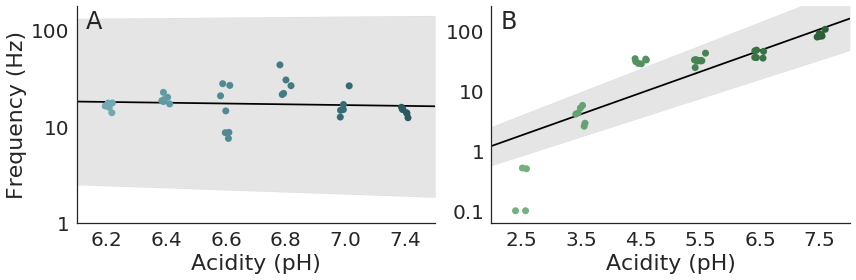

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from statsmodels.api import OLS
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load count data.
counts = read_csv('counts.csv')

## Group by recording.
counts = counts.groupby(['Session','pH','Recording']).Frequency.mean().reset_index()

## Convert to log10.
counts['logFrequency'] = np.log10(counts.Frequency)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Regression models.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Fit model to first session.
fit1 = OLS.from_formula('logFrequency ~ pH', data=counts[counts.Session==171208]).fit()
print('Session 1: Conservative pH Range')
print(fit1.summary2())

## Fit model to second session.
fit2 = OLS.from_formula('logFrequency ~ pH', data=counts[counts.Session==171212]).fit()
print('Session 2: Extreme pH Range')
print(fit2.summary2())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Define useful function.
fx = lambda x, a, b: a + b * x

## Define plotting 
palettes = [sns.cubehelix_palette(start=2.5, rot=0, dark=0.3, light=.6),
            sns.cubehelix_palette(start=2, rot=0, dark=0.3, light=.6)]
labels = ['A', 'B']

## Iteratively plot.
for i, ax, session, fit, palette, label in zip(range(2), axes, counts.Session.unique(), 
                                               [fit1,fit2], palettes, labels):
    
    ## Restrict data.
    data = counts[counts.Session==session].copy()
    
    ## Plot points.
    sns.stripplot('pH', 'logFrequency', data=data, jitter=True, size=7, palette=palette, ax=ax)
    
    ## Plot regression line.
    x = np.linspace(data.pH.min(), data.pH.max(), 100)
    y = fx(x, *fit.params)
    ax.plot(np.linspace(*ax.get_xlim(), 100), y, color='k')
    
    ## Plot confidence interval.
    lb = fx(x, *(fit.params - fit.bse))
    ub = fx(x, *(fit.params + fit.bse))
    ax.fill_between(np.linspace(*ax.get_xlim(), 100), lb, ub, color='k', alpha=0.1)
    
    ## Add info.
    ax.set(xlabel='Acidity (pH)')
    if not i: ax.set(yticks=[0,1,2], yticklabels=[1, 10, 100], ylabel='Frequency (Hz)')
    else: ax.set(ylim=(-1.2,2.4), yticks=[-1,0,1,2], yticklabels=[0.1, 1, 10, 100], ylabel='')
    ax.annotate(label, xy=(0,0), xytext=(0.025,0.9), xycoords='axes fraction', fontsize=24)
    
sns.despine()
plt.tight_layout()